In [43]:
import os
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
#warnings.filterwarnings("ignore") #Hide messy Numpy warnings


In [44]:
def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [45]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [46]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
    output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

In [47]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [48]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

In [49]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]            
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [50]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


In [51]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [52]:
global_start_time = time.time()
epochs  = 100
#seq_len = 50
seq_len = 5

In [53]:
f = open('sp500.csv', 'rb').read()
data = f.decode().split('\n')
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])
result[0:2]

[['1455.219971',
  '1399.420044',
  '1402.109985',
  '1403.449951',
  '1441.469971',
  '1457.599976'],
 ['1399.420044',
  '1402.109985',
  '1403.449951',
  '1441.469971',
  '1457.599976',
  '1438.560059']]

In [54]:
#normalise_window = True
normalise_window = False
if normalise_window:
    result = normalise_windows(result)
result[0:2]

[['1455.219971',
  '1399.420044',
  '1402.109985',
  '1403.449951',
  '1441.469971',
  '1457.599976'],
 ['1399.420044',
  '1402.109985',
  '1403.449951',
  '1441.469971',
  '1457.599976',
  '1438.560059']]

In [55]:
result = np.array(result)
result.shape

(4166, 6)

In [56]:
#row = round(0.9 * result.shape[0])
row = round(0.7 * result.shape[0])
train = result[:int(row), :]
# shuffle ?! why that
#np.random.shuffle(train)
x_train = train[:, :-1]
x_train[0:2]

array([['1455.219971', '1399.420044', '1402.109985', '1403.449951',
        '1441.469971'],
       ['1399.420044', '1402.109985', '1403.449951', '1441.469971',
        '1457.599976']], 
      dtype='<U11')

In [57]:
y_train = train[:, -1]
y_train[0:2]

array(['1457.599976', '1438.560059'], 
      dtype='<U11')

In [58]:
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1]


In [59]:
x_test[0:2]

array([['1199.380005', '1119.459961', '1172.530029', '1120.76001',
        '1172.640015'],
       ['1119.459961', '1172.530029', '1120.76001', '1172.640015',
        '1178.810059']], 
      dtype='<U11')

In [60]:
y_test[0:2]

array(['1178.810059', '1204.48999'], 
      dtype='<U11')

In [62]:
x_train.shape, y_train.shape, x_test.shape,  y_test.shape

((2916, 5), (2916,), (1250, 5), (1250,))

In [63]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2916, 5, 1), (1250, 5, 1), (2916,), (1250,))

In [18]:
layers = [1, 50, 100, 1]

model = Sequential()

model.add(LSTM(input_dim=layers[0], output_dim=layers[1], return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(layers[2], return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=layers[3]))

model.add(Activation("linear"))
model

In [19]:
start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
print("> Compilation Time : ", time.time() - start)

> Compilation Time :  0.16230106353759766


In [20]:
model.fit(x_train, y_train, batch_size=512, nb_epoch=epochs, validation_split=0.05)

Train on 2770 samples, validate on 146 samples
Epoch 1/100
2770/2770 [==============================] - 0s - loss: 1448356.8534 - val_loss: 1406129.3750
Epoch 2/100
2770/2770 [==============================] - 0s - loss: 1440578.6484 - val_loss: 1396438.1250
Epoch 3/100
2770/2770 [==============================] - 0s - loss: 1430357.9394 - val_loss: 1386935.1250
Epoch 4/100
2770/2770 [==============================] - 0s - loss: 1422119.5252 - val_loss: 1381513.7500
Epoch 5/100
2770/2770 [==============================] - 0s - loss: 1417479.6450 - val_loss: 1378287.5000
Epoch 6/100
2770/2770 [==============================] - 0s - loss: 1414692.2269 - val_loss: 1376235.0000
Epoch 7/100
2770/2770 [==============================] - 0s - loss: 1412658.9696 - val_loss: 1374637.7500
Epoch 8/100
2770/2770 [==============================] - 0s - loss: 1411188.8737 - val_loss: 1373212.2500
Epoch 9/100
2770/2770 [==============================] - 0s - loss: 1409755.3438 - val_loss: 1371834.2500

2770/2770 [==============================] - 0s - loss: 1318792.7093 - val_loss: 1282395.8750
Epoch 78/100
2770/2770 [==============================] - 0s - loss: 1317586.4643 - val_loss: 1281111.3750
Epoch 79/100
2770/2770 [==============================] - 0s - loss: 1316351.2274 - val_loss: 1279828.0000
Epoch 80/100
2770/2770 [==============================] - 0s - loss: 1314828.9247 - val_loss: 1278546.7500
Epoch 81/100
2770/2770 [==============================] - 0s - loss: 1313643.2332 - val_loss: 1277264.1250
Epoch 82/100
2770/2770 [==============================] - 0s - loss: 1312167.1180 - val_loss: 1275982.6250
Epoch 83/100
2770/2770 [==============================] - 0s - loss: 1311015.5329 - val_loss: 1274704.3750
Epoch 84/100
2770/2770 [==============================] - 0s - loss: 1309925.2418 - val_loss: 1273429.7500
Epoch 85/100
2770/2770 [==============================] - 0s - loss: 1308380.9586 - val_loss: 1272150.8750
Epoch 86/100
2770/2770 [==========================

In [66]:
# predict point by point
predicted = model.predict(x_test)
predicted

array([[ 70.33676147],
       [ 70.33676147],
       [ 70.33676147],
       ..., 
       [ 70.33676147],
       [ 70.33676147],
       [ 70.33676147]], dtype=float32)

In [67]:
predicted = np.reshape(predicted, (predicted.size,))
predicted

array([ 70.33676147,  70.33676147,  70.33676147, ...,  70.33676147,
        70.33676147,  70.33676147], dtype=float32)

In [68]:
len(predicted), len(x_test)

(1250, 1250)

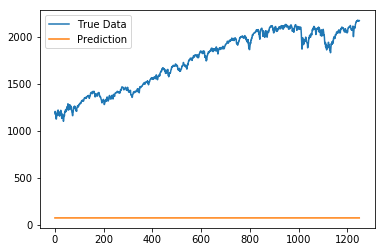

In [23]:
predictions1 = predict_point_by_point(model, x_test)    
plot_results(predictions1, y_test)

In [69]:
#Predict sequence of 50 steps before shifting prediction run forward by 50 steps
#prediction_len=50
prediction_len=5
prediction_seqs = []
for i in range(int(len(x_test)/prediction_len)):
    curr_frame = x_test[i*prediction_len]
    predicted = []
    for j in range(prediction_len):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]            
        curr_frame = np.insert(curr_frame, [seq_len-1], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
prediction_seqs

[[70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 7

In [65]:
#predictions3 = predict_sequences_multiple(model, x_test, seq_len, 50)
predictions3 = predict_sequences_multiple(model, x_test, seq_len, 5)
predictions3
#plot_results_multiple(predictions3, y_test, 50)

[[70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 70.336746, 70.336746, 70.336746, 70.336746],
 [70.336746, 7

In [26]:
#Shift the window by 1 new prediction each time, re-run predictions on new window
curr_frame = x_test[0]
predicted = []
for i in range(len(x_test)):
    predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
    curr_frame = curr_frame[1:]
    curr_frame = np.insert(curr_frame, [seq_len-1], predicted[-1], axis=0)
predicted

[70.336746,
 70.336746,
 70.336746,
 70.336746,
 70.336746,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.336739,
 70.

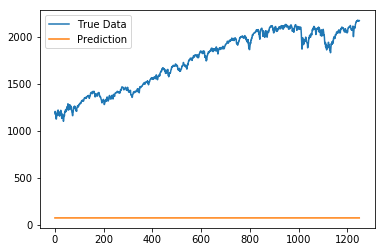

In [27]:
predictions2 = predict_sequence_full(model, x_test, seq_len)
plot_results(predictions2, y_test)